In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.getenv("HOME") + "/git/github.com/dnswlt/hexz/pyhexz/src")

from pyhexz import modelrepo
from pyhexz.hexc import CBoard
from pyhexz.hexz import HexzNeuralNetwork
from pyhexz import hexz_pb2, training
import gzip


# Inspect model weights

In [11]:
repo = modelrepo.LocalModelRepository(os.getenv("HOME") + "/git/github.com/dnswlt/hexz-models")

In [119]:
model = repo.get_model("harlem")
#model = HexzNeuralNetwork()
_ = model.train()

In [49]:
board = CBoard()

In [79]:
pr_loss_fn = nn.CrossEntropyLoss()
val_loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(
            model.parameters(),
            lr=1e-3,
            weight_decay=1e-4
        )

In [115]:
b = torch.from_numpy(board.b)
assert b.shape == (11, 11, 10)
action_mask = torch.stack((1 - b[2], torch.zeros((11,10)))).bool()
assert action_mask.shape == (2, 11, 10)

optimizer.zero_grad()
pred_pr, pred_val = model(b.unsqueeze(0), action_mask.unsqueeze(0))
pred_pr.sum().backward()
#pr_loss = pr_loss_fn(pred_pr.flatten(1), y_pr.flatten(1))
#val_loss = val_loss_fn(pred_val, y_val)
#loss = pr_loss + val_loss
#loss.backward()

In [54]:
ps = list(model.parameters())

In [55]:
len(ps)

27

In [56]:
len(model.state_dict())

48

In [58]:
next(iter(model.state_dict()))

'cnn_blocks.0.0.weight'

cnn_blocks.1.1.running_var <class 'torch.Tensor'> torch.float32


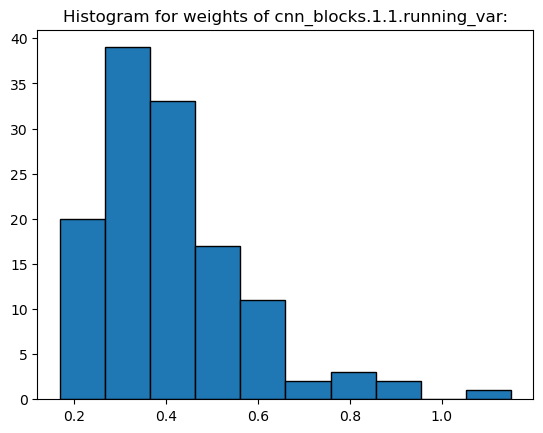

cnn_blocks.1.1.num_batches_tracked <class 'torch.Tensor'> torch.int64
skipping dict entry cnn_blocks.1.1.num_batches_tracked with type torch.int64
cnn_blocks.2.0.weight <class 'torch.Tensor'> torch.float32


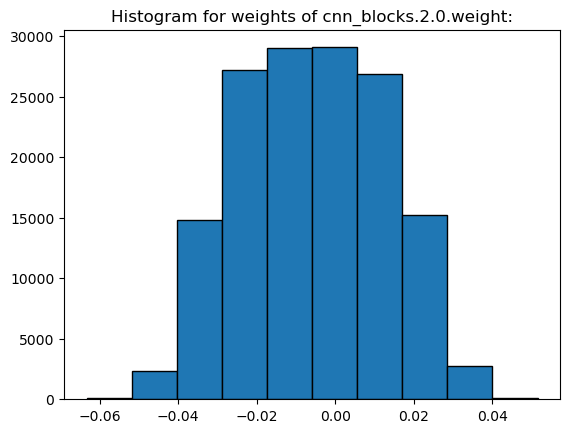

cnn_blocks.2.1.weight <class 'torch.Tensor'> torch.float32


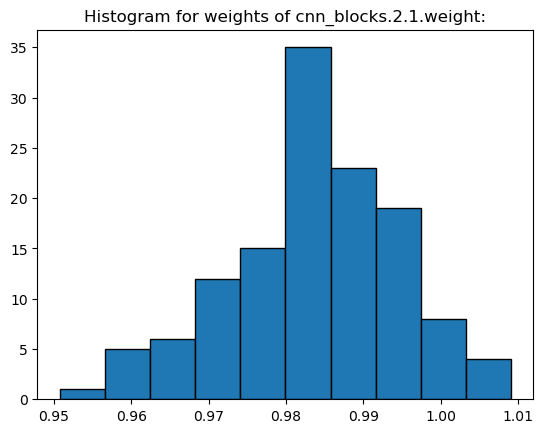

cnn_blocks.2.1.bias <class 'torch.Tensor'> torch.float32


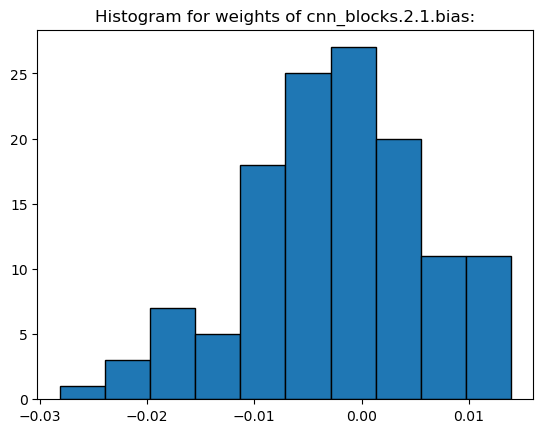

cnn_blocks.2.1.running_mean <class 'torch.Tensor'> torch.float32


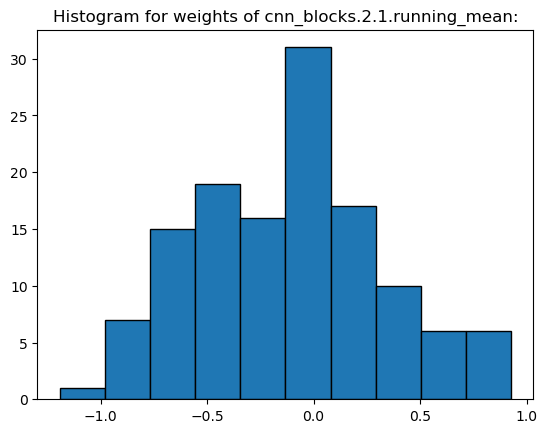

In [98]:
# Histogram of weight values
for i, (key, ws) in enumerate(model.state_dict().items()):
    if i < 10 or i > 15:
        continue
    print(key, type(ws), ws.dtype)
    if ws.dtype not in [torch.float32]:
        print(f"skipping dict entry {key} with type {ws.dtype}")
        continue
    hist, edges = torch.histogram(ws.flatten(), bins=10)
    plt.bar(edges[:-1], hist, width=edges[1]-edges[0], edgecolor='black')
    plt.title(f"Histogram for weights of {key}:")
    plt.show()


In [120]:
def gradient_hook(module, input_grad, output_grad):
    print(module, output_grad[0].abs().mean().item())

try:
    hook_handles = [None] * len(model.cnn_blocks)
    for i, block in enumerate(model.cnn_blocks):
        hook_handles[i] = block.register_full_backward_hook(gradient_hook)
    optimizer.zero_grad()
    pred_pr, pred_val = model(b.unsqueeze(0), action_mask.unsqueeze(0))
    pred_pr.sum().backward()
finally:
    for h in hook_handles:
        h.remove()

Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
) 0.019482463598251343
Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
) 0.009648725390434265
Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
) 0.007945925928652287
Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
) 0.015908150002360344
Sequential(
  (0): Conv2d(11, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm

# Living on the edge

Why on earth does the network reliably and repeatably start to think that it should place flags in the corners?

In [4]:
import glob
from collections import defaultdict

MODEL_REPO_BASE_DIR="/tmp/hexz-models"

def read_reqs(model="edgar"):
    """Read all AddTrainingExamplesRequest files for the given model."""
    result = []
    efiles = glob.glob(f"{MODEL_REPO_BASE_DIR}/models/flagz/{model}/checkpoints/*/examples/*.gz")
    for f in efiles:
        r = hexz_pb2.AddTrainingExamplesRequest.FromString(gzip.open(f).read())
        result.append(r)
    return result

def filter_ex(reqs, move=[], cp=[]):
    """Returns a list of TrainingExample from the given AddTrainingExamplesRequest list,
    filtered by the specified criteria.
    """
    cps = cp if isinstance(cp, list) else [cp]
    moves = move if isinstance(move, list) else [move]
    def p(r, e):
        return (
            (not cps or r.model_key.checkpoint in cps) and
            (not moves or e.move.move in moves)
        )
    es = []
    for r in reqs:
        for e in r.examples:
            if p(r, e):
                es.append(e)
    return es

reqs = read_reqs()
print(f"Read {len(reqs)} training examples.")
d = defaultdict(lambda: [])
for r in reqs:
    d[r.model_key.checkpoint].append(r)
epc = { k: len(v) for k, v in sorted(d.items()) }
print(f"Examples per checkpoint: {epc}")

Read 764 training examples.
Examples per checkpoint: {0: 30, 1: 25, 2: 24, 3: 25, 4: 25, 5: 25, 6: 25, 7: 24, 8: 26, 9: 25, 10: 25, 11: 25, 12: 26, 13: 44, 14: 25, 15: 25, 16: 25, 17: 25, 18: 25, 19: 25, 20: 26, 21: 25, 22: 26, 23: 26, 24: 26, 25: 25, 26: 26, 27: 26, 28: 27, 29: 7}


In [5]:
avg_ex_per_req = sum(len(t.examples) for t in reqs) / len(reqs)
print(f"Avg. number of examples per request: {avg_ex_per_req}")


Avg. number of examples per request: 40.74083769633508


In [6]:
from itertools import islice
def batched(iterable, n):
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while batch := list(islice(it, n)):
        yield batch

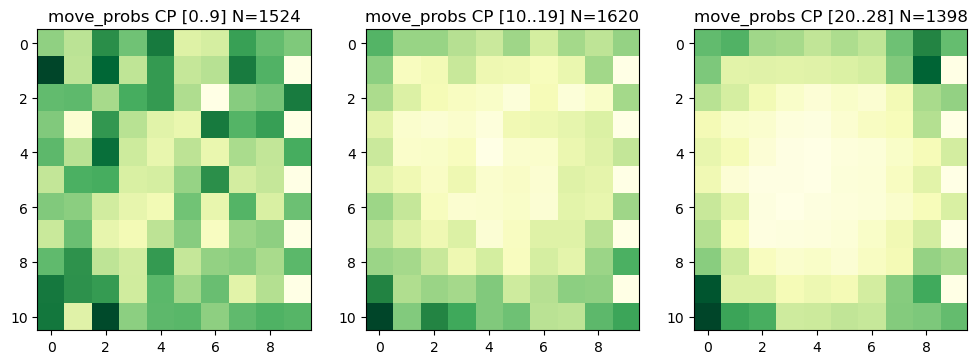

In [20]:
# Adjust these values to look at different moves and checkpoint ranges.

moves=[0,1,2,3,4,5]
checkpoints = list(batched(range(max(map(lambda r: r.model_key.checkpoint, reqs))), 10))

fig, axs = plt.subplots(1, len(checkpoints), figsize=(12, 5))

for i, cps in enumerate(checkpoints):
    prs = [training.NumpyExample.decode(e).move_probs for e in filter_ex(reqs, move=moves, cp=cps)]
    Xs = np.array(prs)
    S = Xs.mean(axis=0)
    F = S[0]
    Fmin = F[F.nonzero()].min()
    axs[i].imshow(F.clip(min=Fmin), cmap='YlGn', interpolation='nearest')
    axs[i].set_title(f"move_probs CP [{min(cps)}..{max(cps)}] N={len(prs)}")

No priors for batch 0


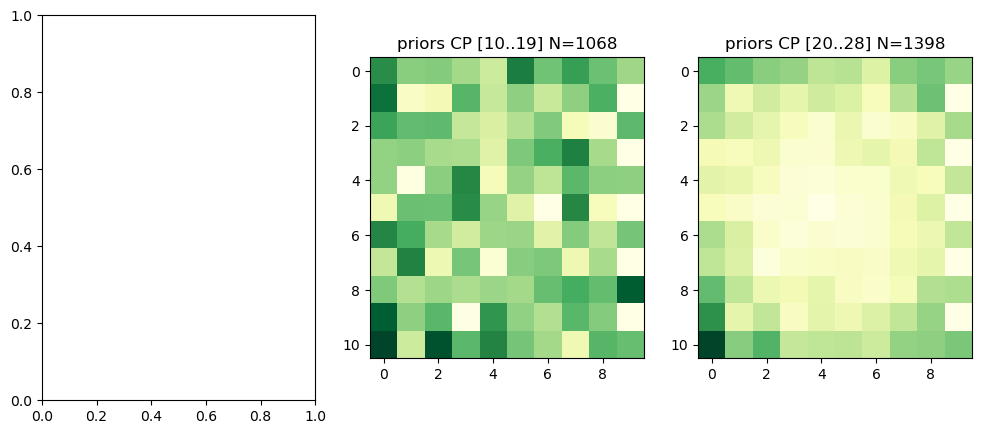

In [23]:
# Adjust these values to look at different moves and checkpoint ranges.

moves=[0,1,2,3,4,5]
checkpoints = list(batched(range(max(map(lambda r: r.model_key.checkpoint, reqs))), 10))

fig, axs = plt.subplots(1, len(checkpoints), figsize=(12, 5))

for i, cps in enumerate(checkpoints):
    priors = [training.NumpyExample.decode(e).priors for e in filter_ex(reqs, move=moves, cp=cps)]
    priors = [p for p in priors if p is not None]
    if not priors:
        print(f"No priors for batch {i}")
        continue
    Xs = np.array(priors)
    S = Xs.mean(axis=0)
    F = S[0]
    Fmin = F[F.nonzero()].min()
    axs[i].imshow(F.clip(min=Fmin), cmap='YlGn', interpolation='nearest')
    axs[i].set_title(f"priors CP [{min(cps)}..{max(cps)}] N={len(priors)}")

In [15]:
Fmin = F[F.nonzero()].min()
print(f"Min/max nonzero move probs in %:\nmin: {Fmin*100}\nmax: {F.max()*100}")

Min/max nonzero move probs in %:
min: 0.38899502251297235
max: 2.075580134987831


Move# min/max: 4.0 21.0
Value min/max: 0.0 0.0
Move# min/max: 5.0 26.0
Value min/max: -0.01878685737028718 1.0208544619381428
Move# min/max: 2.0 36.0
Value min/max: -1.6222806069999933 0.8565462940605357


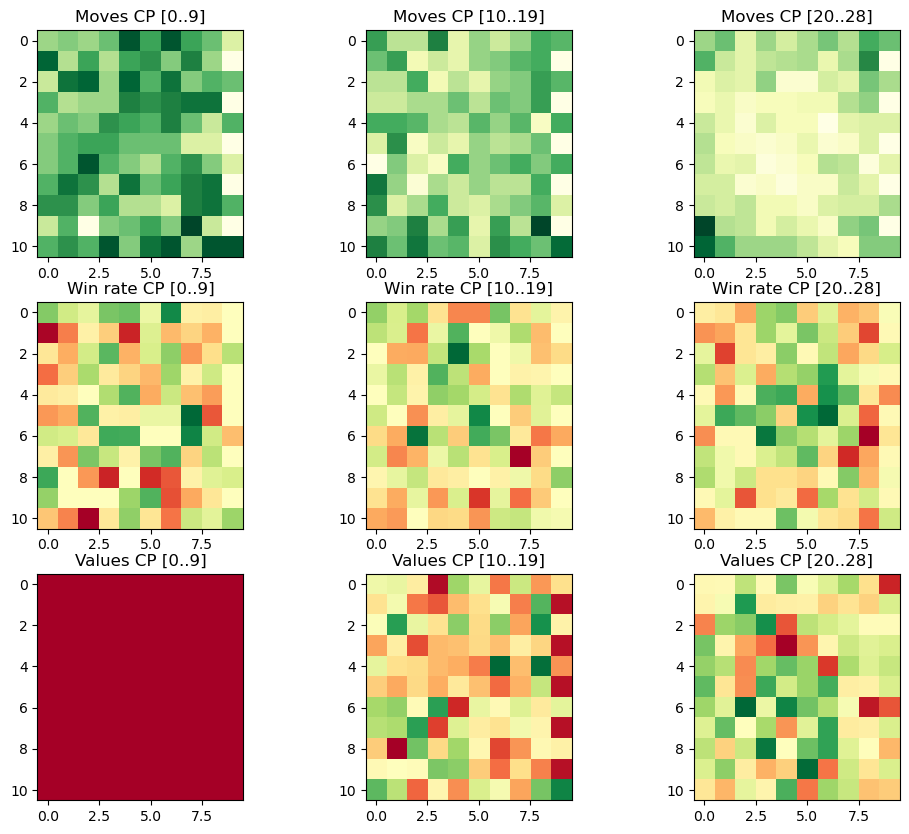

In [17]:
fig, axs = plt.subplots(3, len(checkpoints), figsize=(12, 10))

for i, cps in enumerate(checkpoints):
    xs = [e for e in filter_ex(reqs, move=moves, cp=cps)]
    t = np.zeros((2, 11, 10))
    w = np.zeros((2, 11, 10))
    v = np.zeros((2, 11, 10))
    for x in xs:
        m = x.move
        typ = 0 if m.cell_type == hexz_pb2.Field.FLAG else 1        
        t[typ][m.row][m.col] += 1
        w[typ][m.row][m.col] += x.result
        v[typ][m.row][m.col] += x.model_predictions.value
    M = t[0]
    Mmin = M[M.nonzero()].min()
    print("Move# min/max:", Mmin, M.max())
    print("Value min/max:", v[0].min(), v[0].max())
    Ws = w[0] / (t[0] + 1)
    Vs = v[0] / (t[0] + 1)
    axs[0, i].imshow(M.clip(min=Mmin), cmap='YlGn', interpolation='nearest')
    axs[0, i].set_title(f"Moves CP [{min(cps)}..{max(cps)}]")
    axs[1, i].imshow(Ws, cmap='RdYlGn', interpolation='nearest')
    axs[1, i].set_title(f"Win rate CP [{min(cps)}..{max(cps)}]")
    axs[2, i].imshow(Vs, cmap='RdYlGn', interpolation='nearest')
    axs[2, i].set_title(f"Values CP [{min(cps)}..{max(cps)}]")
    
